# 🏆 VLM: Finetuning
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/1337-Artificial-Intelligence/hackai-2025/blob/main/notebooks/vlm_finetuning.ipynb)

As you learned in the [VLM Usage notebook](https://colab.research.google.com/github/1337-Artificial-Intelligence/hackai-2025/blob/main/notebooks/vlm_usage.ipynb)
, Vision-Language Models (VLMs) are type of models that can understand both images and text and perform various tasks, one of which is Visual Question Answering (VQA). However, they may struggle to understand the nuances of the Darija dialect.
In this notebook, we will fine-tune a VLM to better understand and respond to questions in Darija.

## Model Diagram: Trained & Frozen Parts

In this challenge, we're going to fine-tune the [Qwen2-VL-7B-Instruct](https://huggingface.co/Qwen/Qwen2-VL-7B-Instruct) model. This VLM consists of three key components:

- Vision Encoder (ViT) – processes images

- Language Model (QwenLM) – generates and understands text

- Projector (CrossAttn) – connects visual features to the language model

The diagram below illustrates the model's development stages.

**😅 Don’t Freak Out!**

Since the model is already pre-trained, we're not going to do all the stages—just the final one: Supervised Fine-tuning on a specific task and dataset.


<p align="center" >
  <img src="https://images.prismic.io/encord/65e0b83727237c2bb829aa59_image5.png?auto=format,compress" width="650" title="Qwen2 VL Training Stages"/>
</p>

🔹 **Stage 1: Pretraining**

In this initial phase, only the vision encoder and the projector are trained using image-text pairs with low-resolution images.
The goal is to help the model learn basic vision-language alignment, like:
 “What does this image generally describe in words?”


🔸 **Stage 2: Multi-task Pretraining**

Now, all three components (ViT, projector, and LLM) are trained on multi-task and interleaved vision-language datasets (VQA, OCR, ..) with high-resolution images. This stage helps the model understand and reason across a wide variety of complex tasks.

🔸 **Stage 3: Supervised Fine-tuning (What we’ll Redo!)**

In this final stage, the model is tuned for chat-style, task-specific performance. Only the LLM is fine-tuned (the ViT is frozen)

Trained on chat-interleaved VL data, such as:

🗨️ User: “What is written on this sign?”

🗨️ Model: “It says ‘Caution: Wet Floor.’”

This stage helps the model become better at giving helpful, natural answers in interactive settings.

## Finetuning

### 1. Install Dependencies

Let’s start by installing the essential libraries we’ll need for fine-tuning! 🚀


In [ ]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer
    !pip install --no-deps unsloth

Authenticate with your Hugging Face account to save and share your model directly from this notebook 🗝️.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

### 2. Load Model


Next, we’ll load the model and the tokenizer to prepare for finetuning/inference.

In [ ]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2.5-VL-7B-Instruct-bnb-4bit",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

We can finetune ONLY the **Vision Encoder** part of the model, or ONLY the **LLM** part. Or you can select both! You can also select to finetune the attention or the MLP layers!

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

### 3. Load Dataset 📁

We’ll load the [Darija-VLM-Dataset](https://huggingface.co/datasets/HackAI-2025/Darija-VLM-Dataset) dataset, which provides images along with corresponding questions and answers for fine-tuning visual question-answering models.

In [ ]:
from datasets import load_dataset
dataset = load_dataset("HackAI-2025/darija-vlm-dataset", split = "train")

Let's take an overview look at the dataset. We shall see what the 2nd image is, and what caption it had.

In [ ]:
dataset

In [ ]:
print("Question: ", dataset[2]["question"])
print("Answer: ", dataset[2]["answer"])

dataset[2]["image"]

We will split the dataset into:
- Train : 80% to finetune the model
- Validation : 10% to validate the model during the finetuning
- Test : 10% to test the model after the finetuning

In [ ]:
train_valtest = dataset.train_test_split(test_size=0.2, seed=42, shuffle=True)
train_ds = train_valtest["train"]
valtest_dataset = train_valtest["test"]

val_test = valtest_dataset.train_test_split(test_size=0.5, seed=42, shuffle=True)
val_ds = val_test["train"]
test_ds = val_test["test"]

print(f"Train dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(val_ds)}")
print(f"Test dataset size: {len(test_ds)}")

We’ll format the dataset into a chatbot structure, with the system message, image, user query, and answer for each interaction.

```python
[
{
"role": "system",
"content": [{"type": "text", "text": system_message}]
}
{ "role": "user",
  "content": [{"type": "text",  "text": Q}, {"type": "image", "image": image} ]
},
{ "role": "assistant",
  "content": [{"type": "text",  "text": A} ]
},
]
```

In [ ]:
system_message = """You are a Vision Language Model (VLM), designed to understand, describe, and explain everything that appears in images.
Your job is to extract meaningful information from what you see, and provide clear and contextually relevant answers, in Moroccan Darija."""

def convert_to_conversation(sample):
    conversation = [
        {
          "role": "system",
          "content": [{"type": "text", "text": system_message}]
        },
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : sample['question']},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["answer"]} ]
        },
    ]
    return { "messages" : conversation }

Now, let’s format the data using the chatbot structure. This will set up the interactions for the model.

In [ ]:
train_dataset = [convert_to_conversation(sample) for sample in train_ds]
val_dataset = [convert_to_conversation(sample) for sample in val_ds]
test_dataset = [convert_to_conversation(sample) for sample in test_ds]

First, let’s inspect the internal structure of the dataset after formating it to understand how it is organized and visualize some examples of images, questions and their corresponding answers.

In [ ]:
train_dataset[0]

<a name="Train"></a>
###4. Train the model
We will use Supervised Fine-Tuning (SFT) to improve our model's performance on the VQA task. To achieve this, we'll define the training arguments with the [SFTConfig](https://huggingface.co/docs/trl/sft_trainer) class from the [TRL library](https://huggingface.co/docs/trl/index). SFT leverages labeled data to help the model generate more accurate responses, adapting it to the task. This approach enhances the model's ability to understand and respond to visual queries more effectively.

We use `UnslothVisionDataCollator` which will help in our vision finetuning setup.

In [ ]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

# num_steps = (len(train_dataset) // batch_size) * epochs

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    args = SFTConfig(
        output_dir="Qwen2-VL-7B-Instruct-Darija-VQA",
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        warmup_steps=5,
        max_steps = 50,
        # num_train_epochs=1, # Set this instead of max_steps for full training runs
        learning_rate=2e-4,
        fp16=not is_bf16_supported(),
        bf16=is_bf16_supported(),
        logging_steps=10,
        eval_steps=100,
        eval_strategy="steps",
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        report_to="wandb",     # For Weights and Biases
        push_to_hub=True,
        hub_model_id="username/Qwen2-VL-7B-Instruct-Darija-VQA",
        hub_token="",
        hub_strategy="all_checkpoints",

        # You MUST put the below items for vision finetuning:
        remove_unused_columns=False,
        dataset_text_field="",
        dataset_kwargs={"skip_prepare_dataset": True},
        dataset_num_proc=4,
        max_seq_length=2048,
    ),
)

In [ ]:
trainer_stats = trainer.train()

<a name="Save"></a>
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model.

In [ ]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")
model.push_to_hub("username/lora_model", token = "")
tokenizer.push_to_hub("username/lora_model", token = "")

## Evaluation

### Quantitative Evaluation
Investigating the model’s **Loss**

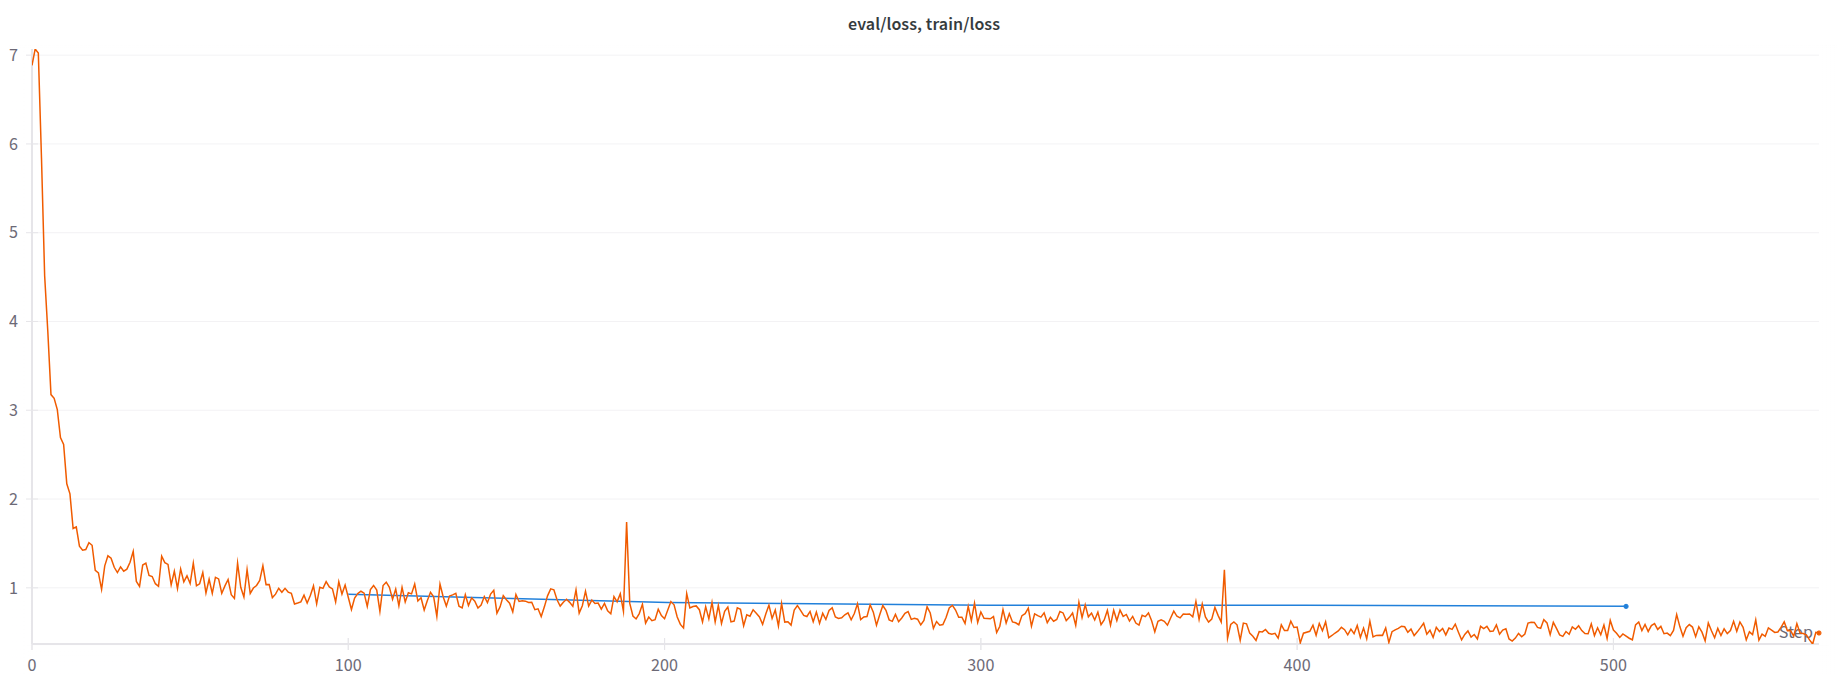


The model loss: The lower it gets, the more correct the model becomes.
In the above curve you’re seeing:

- The orange line is the training loss : How well the model is doing on the data it’s learning from.

- The blue line is the evaluation loss : How well the model performs on unseen data.

What does this chart say?
- Loss starts high (~7), meaning the model initially struggled with the task.
- As training progresses, both training and evaluation loss drop quickly and stabilize around 0.8.

- The parallel decline suggests the model isn’t just memorizing, it’s genuinely learning and generalizing.

### Qualitative Evaluation
Testing how the model responds in practice, beyond just the numbers.

Now that we’ve given our model a crash course on the task on Darija VQA, it’s time to see if it actually learned something!

Let’s test the VLM again and compare its performance before and after fine-tuning.
We’ll use a simple inference function to ask it some questions and observe how its answers have improved (hopefully 🤞).



In [ ]:
def inference(model, tokenizer, messages, image):
  FastVisionModel.for_inference(model) # Enable for inference!

  input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
  inputs = tokenizer(
      image,
      input_text,
      add_special_tokens = False,
      return_tensors = "pt",
  ).to("cuda")

  from transformers import TextStreamer
  text_streamer = TextStreamer(tokenizer, skip_prompt = True)
  _ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                    use_cache = True, temperature = 1.5, min_p = 0.1)

Before finetuning

In [ ]:
test_index = 34
messages = test_dataset[test_index]['messages'][0:2]
image = messages[1]['content'][1]['image']

question = test_dataset[test_index]['messages'][0:2][1]['content'][0]['text']
ground_truth = test_dataset[test_index]['messages'][2]['content'][0]['text']

print("Question: ", question)
print("Original Answer: ", ground_truth)
print("Model Answer: ")

inference(model, tokenizer, messages, image)

In [ ]:
image

The model mentions general architectural terms like "بناء" hinting at some visual cue recognition.

❌ Key Issues:
- Incoherent: Ends with nonsensical, hallucinated phrases.

- Irrelevant: Doesn’t clearly answer if it’s a building.

- Poor Darija Fluency: Awkward and unnatural phrasing.

- No Ground Truth Match: Misses key details like large building, office/company, and mesh decoration.


After finetuning

In [ ]:
# Let's load the finetuned model
from unsloth import FastVisionModel
    finetuned_model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!

In [ ]:
print("Question: ", question)
print("Original Answer: ", ground_truth)
print("Model Answer: ")

inference(finetuned_model, tokenizer, messages, image)

In [ ]:
image

## Challenge

- **How to make training faster?**

- **How to further evaluate the model?**

- **What other dataset would you pick for finetuning?**

**Good luck with the rest of the challenge—and HAVE FUN! 🚀**
___